In [1]:
from MoneyModel import MoneyModel

In [2]:
empty_model = MoneyModel(10)
empty_model.step()

In [3]:
from MoneyModel import *

In [4]:
model = MoneyModel(10)

(array([  0.,   0.,   0.,   0.,   0.,  10.,   0.,   0.,   0.,   0.]),
 array([ 0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5]),
 <a list of 10 Patch objects>)

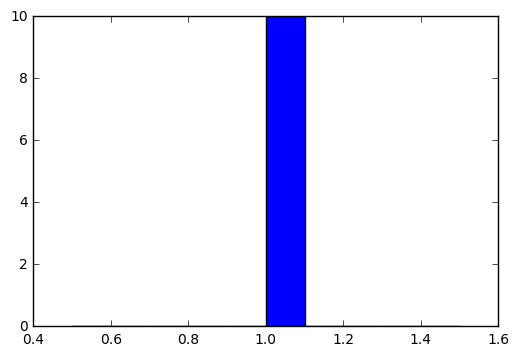

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
agent_wealth = [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealth)

(array([ 420.,  312.,  164.,   70.,   21.,   13.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <a list of 6 Patch objects>)

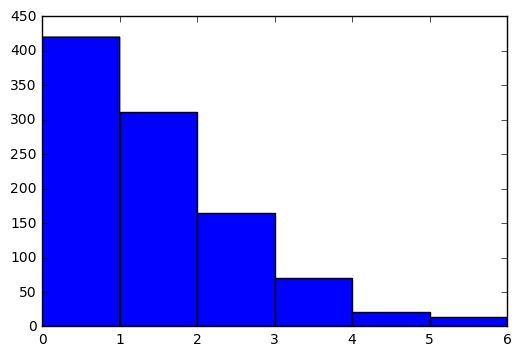

In [6]:
all_wealth = []
for j in range(100):
    # Run the model
    model = MoneyModel(10)
    for i in range(10):
        model.step()

    # Store the results
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)

plt.hist(all_wealth, bins=range(max(all_wealth)+1))

In [17]:
from MoneyModel import *

In [19]:
from mesa import Agent, Model
from mesa.time import RandomActivation
import random
from mesa.space import MultiGrid

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

    def step(self):
        self.schedule.step()

class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

In [20]:
model = MoneyModel(50, 10, 10)

In [21]:
for i in range(20):
    model.step()

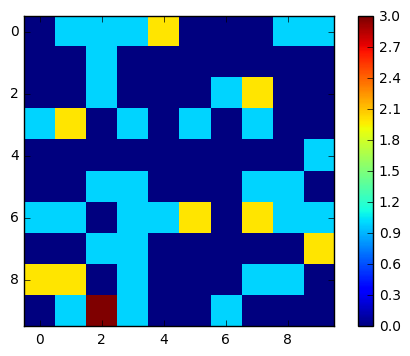

In [22]:
import numpy as np

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

In [23]:
from MoneyModel import *

In [25]:
from mesa import Agent, Model
from mesa.time import RandomActivation
import random
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": lambda a: a.wealth})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

In [26]:
model = MoneyModel(50, 10, 10)

In [27]:
for i in range(100):
    model.step()

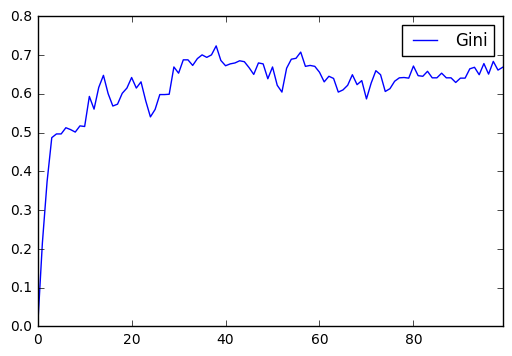

In [28]:
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

In [29]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1

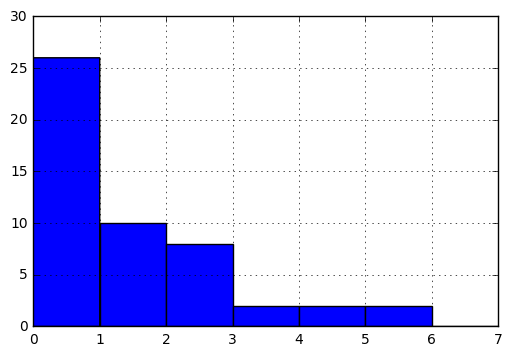

In [30]:
end_wealth = agent_wealth.xs(99, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max()+1))

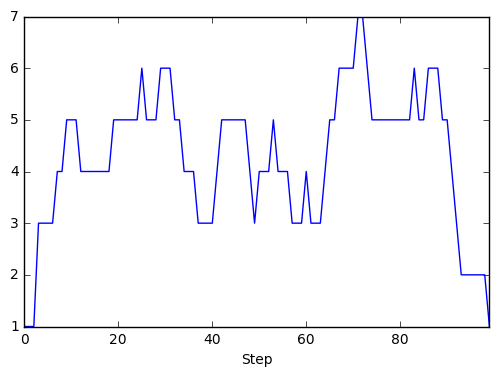

In [31]:
one_agent_wealth = agent_wealth.xs(14, level="AgentID")
one_agent_wealth.Wealth.plot()

In [32]:
from MoneyModel import *

In [34]:
from mesa.batchrunner import BatchRunner
class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": lambda a: a.wealth})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [35]:
parameters = {"width": 10,
              "height": 10,
              "N": range(10, 500, 10)}

batch_run = BatchRunner(MoneyModel,
                        parameters,
                        iterations=5,
                        max_steps=100,
                        model_reporters={"Gini": compute_gini})
batch_run.run_all()

100%|██████████| 245/245 [00:31<00:00,  4.94it/s]


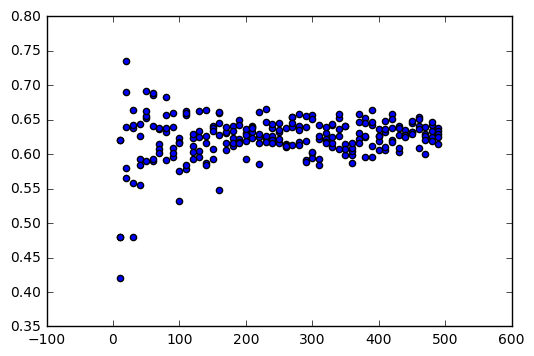

In [36]:
run_data = batch_run.get_model_vars_dataframe()
run_data.head()
plt.scatter(run_data.N, run_data.Gini)